In [9]:
!{sys.executable} -m pip install pandas matplotlib seaborn jupyter prophet


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached notebook-7.3.3-py3-none-any.whl.metadata (10 kB)
  Using cached jupyter_console-6.6.3-py3-none-any.whl.metadata (5.8 kB)
  Using cached nbconvert-7.16.6-py3-none-any.whl.metadata (8.5 kB)
  Using cached ipywidgets-8.1.5-py3-none-any.whl.metadata (2.3 kB)
  Using cached jupyterlab-4.3.6-py3-none-any.whl.metadata (16 kB)
  Using cached widgetsnbextension-4.0.13-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.13-py3-none-any.whl.metadata (4.1 kB)
  Using cached async_lru-2.0.5-py3-none-any.whl.metadata (4.5 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached jupyter_lsp-2.2.5-py3-none-any.whl.metadata (1.8 kB)
  Using cached jupyter_server-2.15.0-py3-none-any.whl.metadata (8.4 kB)
  Using cached jupyterlab_server-2.27.3-py3-non

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet


                     traffic
timestamp                   
2025-03-21 00:00:00      120
2025-03-21 01:00:00      105
2025-03-21 02:00:00       98
2025-03-21 03:00:00       95
2025-03-21 04:00:00       90


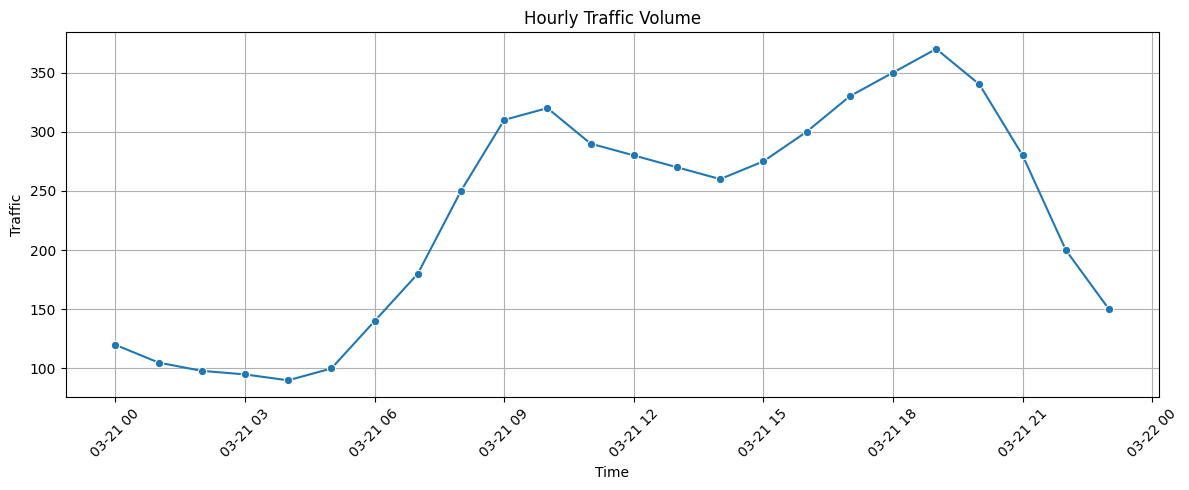

In [11]:


# CSV 파일 불러오기
df = pd.read_csv('../data/traffic_data.csv', parse_dates=['timestamp'])

# 시간 인덱스 설정
df.set_index('timestamp', inplace=True)

# 데이터 확인
print(df.head())

# 시각화
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x=df.index, y='traffic', marker='o')
plt.title("Hourly Traffic Volume")
plt.xlabel("Time")
plt.ylabel("Traffic")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


02:05:54 - cmdstanpy - INFO - Chain [1] start processing
02:05:55 - cmdstanpy - INFO - Chain [1] done processing
c:\AIProject\.venv\lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


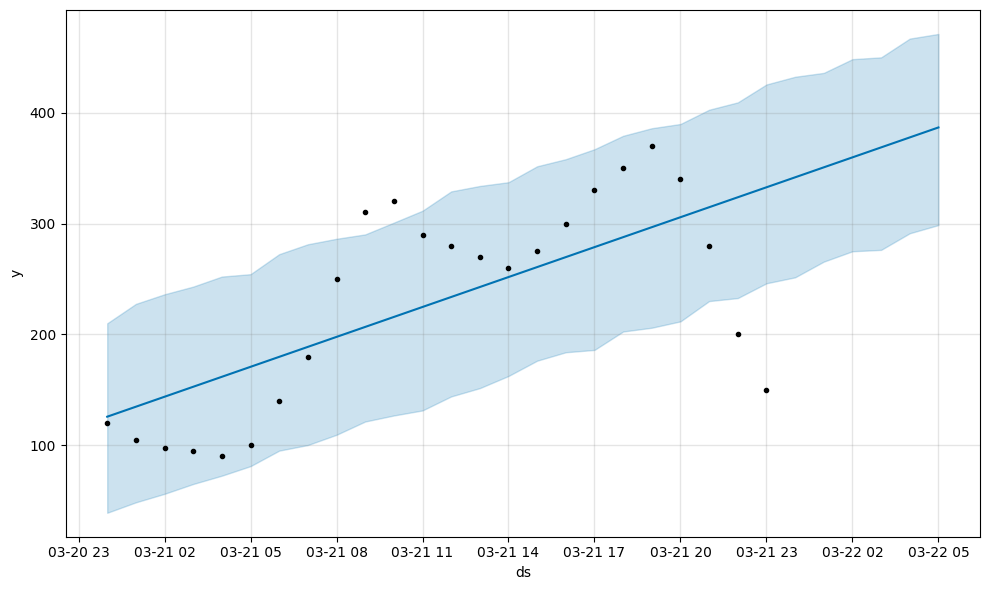

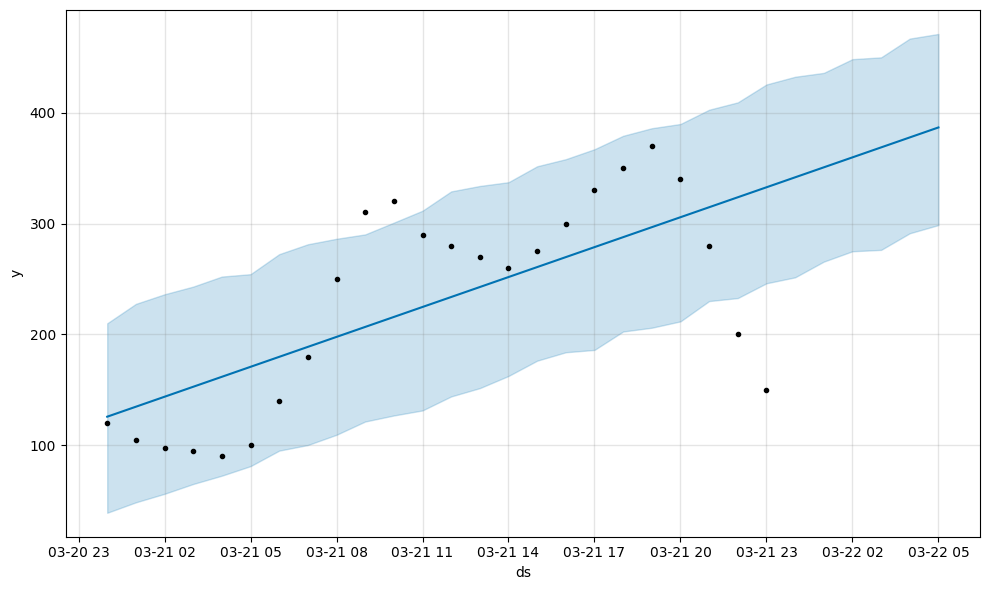

In [12]:
# Prophet 형식으로 데이터 변환
df_prophet = df.reset_index().rename(columns={'timestamp': 'ds', 'traffic': 'y'})

# 모델 학습
model = Prophet()
model.fit(df_prophet)

# 6시간 미래 예측
future = model.make_future_dataframe(periods=6, freq='H')
forecast = model.predict(future)

# 결과 시각화
model.plot(forecast)



In [13]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)


,ds,yhat,yhat_lower,yhat_upper
24,2025-03-22 00:00:00,341.700468,251.519653,432.366516
25,2025-03-22 01:00:00,350.693608,265.675361,435.866110
26,2025-03-22 02:00:00,359.686747,275.016678,448.239923
27,2025-03-22 03:00:00,368.679887,276.266772,449.870702
28,2025-03-22 04:00:00,377.673026,291.250925,466.789966
29,2025-03-22 05:00:00,386.666165,298.648909,470.976808


In [14]:
# 예측 결과에서 ds, yhat, yhat_upper, yhat_lower만 추출
forecast_filtered = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# 실제값과 병합
merged = pd.merge(df_prophet, forecast_filtered, on='ds', how='left')


In [15]:
# 이상 여부 판단: 실제값이 예측 범위를 벗어나면 이상
merged['anomaly'] = (
    (merged['y'] > merged['yhat_upper']) | 
    (merged['y'] < merged['yhat_lower'])
)


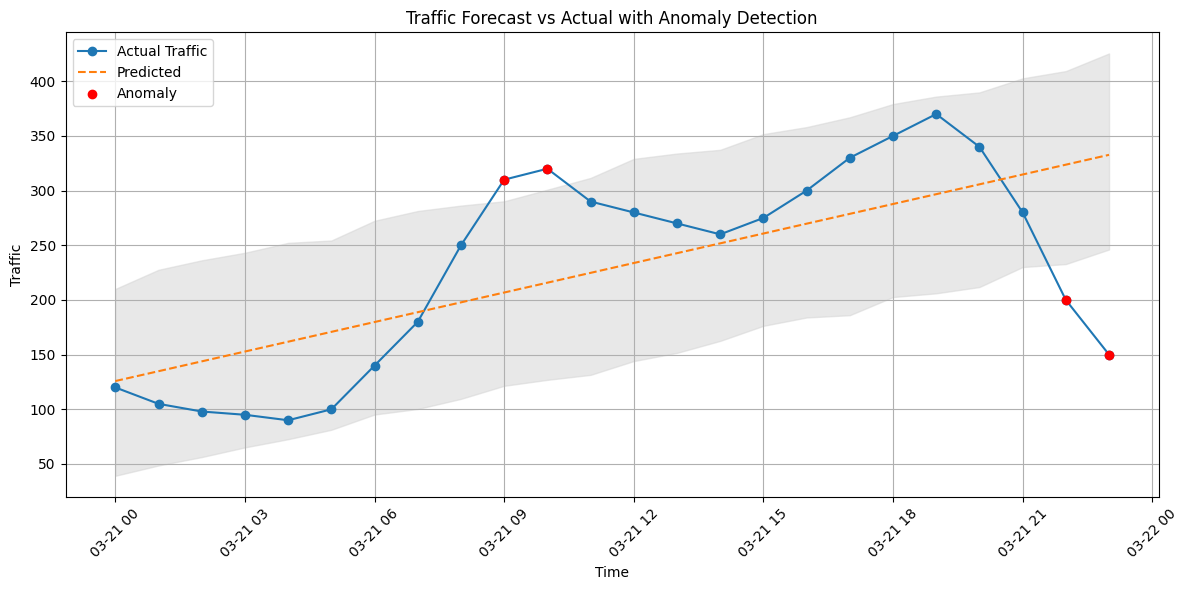

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(merged['ds'], merged['y'], label='Actual Traffic', marker='o')
plt.plot(merged['ds'], merged['yhat'], label='Predicted', linestyle='--')
plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], color='lightgray', alpha=0.5)

# 이상치만 붉은 점으로 표시
anomalies = merged[merged['anomaly']]
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomaly', zorder=10)

plt.legend()
plt.title("Traffic Forecast vs Actual with Anomaly Detection")
plt.xlabel("Time")
plt.ylabel("Traffic")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


In [27]:
from google.cloud import storage
import os

# 1. GCP 인증 키 연결
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "gcp-key.json"

# 2. 예측 결과 CSV로 저장
merged.to_csv("anomaly_result.csv", index=False)

# 3. GCS에 업로드
client = storage.Client()
bucket = client.get_bucket("my-traffic-bucket")  # ← 만든 버킷 이름
blob = bucket.blob("anomaly_result.csv")         # GCS 상에서 저장될 이름
blob.upload_from_filename("anomaly_result.csv")

print("예측 결과가 GCP에 업로드되었습니다!")


예측 결과가 GCP에 업로드되었습니다!


In [34]:
import os
print(os.getcwd())

c:\AIProject\traffic_predictor\notebooks


In [35]:
import pandas as pd

# CSV 경로 (현재 구조에 맞게 수정됨)
df = pd.read_csv("C:/AIProject/traffic_predictor/data/output1.csv")


# 유닉스 타임스탬프를 datetime으로 변환
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# 시간 단위로 트래픽 합산 (Length 기준)
df_hourly = df.resample('H', on='Timestamp')['Length'].sum().reset_index()

# 컬럼 이름 정리
df_hourly.rename(columns={'Timestamp': 'datetime', 'Length': 'traffic'}, inplace=True)

# 확인
print(df_hourly.head())



             datetime    traffic
0 2023-10-09 23:00:00  381011623
1 2023-10-10 00:00:00    7439764


C:\Users\wkrld\AppData\Local\Temp\ipykernel_15200\3143337771.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H', on='Timestamp')['Length'].sum().reset_index()


In [ ]:
print(" 시작 시간:", df['Timestamp'].min())
print(" 끝 시간:", df['Timestamp'].max())



🕐 시작 시간: 2023-10-09 23:39:16.945463896
🕛 끝 시간: 2023-10-10 00:00:13.867471933


In [41]:
import pandas as pd

df = pd.read_csv('C:/AIProject/traffic_predictor/data/Midterm_53_group.csv')
print(df.columns)
print(df.head())


Index(['Time', 'Source', 'No.', 'Destination', 'Protocol', 'Length', 'Info'], dtype='object')
       Time           Source  ...  Length                                     Info
0  0.000000    192.167.8.166  ...      92                   Name query NB WPAD<00>
1  0.784682    192.167.8.166  ...      92                   Name query NB WPAD<00>
2  1.169060  VMware_8a:5c:e6  ...      60  Who has 192.167.7.175? Tell 192.167.0.1
3  2.167949  VMware_8a:5c:e6  ...      60  Who has 192.167.7.175? Tell 192.167.0.1
4  3.170095  VMware_8a:5c:e6  ...      60  Who has 192.167.7.175? Tell 192.167.0.1

[5 rows x 7 columns]


In [42]:
import pandas as pd

# Midterm CSV 불러오기
df = pd.read_csv('../data/Midterm_53_group.csv')

# 0초 기준 datetime으로 변환
start_time = pd.to_datetime("2023-01-01 00:00:00")
df['datetime'] = df['Time'].apply(lambda x: start_time + pd.to_timedelta(x, unit='s'))

# 분 단위로 트래픽 합산
df_agg = df.resample('T', on='datetime')['Length'].sum().reset_index()
df_agg.rename(columns={'Length': 'traffic'}, inplace=True)

# 시계열 추출
series = df_agg['traffic'].values


C:\Users\wkrld\AppData\Local\Temp\ipykernel_15200\4160648779.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_agg = df.resample('T', on='datetime')['Length'].sum().reset_index()


In [43]:
print("시계열 길이:", len(series))


시계열 길이: 21
